In [25]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from utils import group_boxplot, lighten_boxplot, multi_group_plot_wrapper
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import calpgs
from tqdm import tqdm

np.random.seed(42)
plt.rcParams["font.family"] = "Arial"

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Variable slope simulation

In [26]:
def calibrate_pred(params, df):
    df = df.copy()
    df["const"] = 1
    dict_params = dict()
    for group in ["beta", "gamma", "slope"]:
        group_params = params.loc[
            [col for col in params.index if col.endswith(group)], "est"
        ]
        if group_params.shape[0] == 0:
            continue
        group_params.index = [col.split(".")[0] for col in group_params.index]
        dict_params[group] = group_params
    mean = df[dict_params["beta"].index].dot(dict_params["beta"])
    if "slope" in dict_params:
        mean *= 1 + df[dict_params["slope"].index].dot(dict_params["slope"])
    std = np.sqrt(np.exp(df[dict_params["gamma"].index].dot(dict_params["gamma"])))
    df_mean_std = pd.concat([mean, std], axis=1)
    df_mean_std.columns = ["mean", "std"]
    return df_mean_std

In [27]:
DATASET = "variable_slope_large"

## Example data

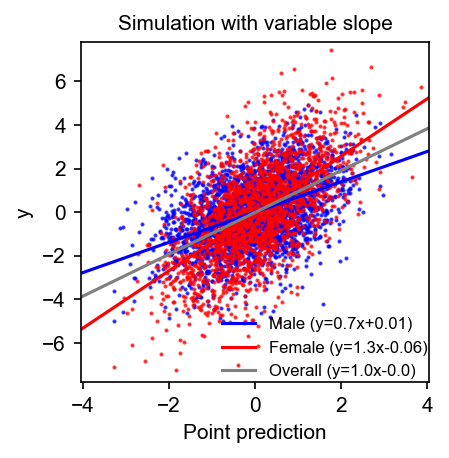

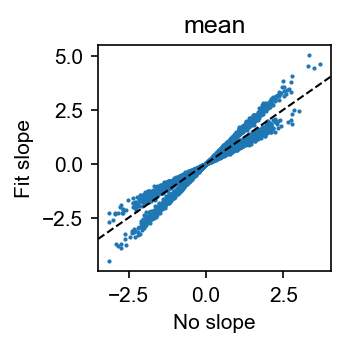

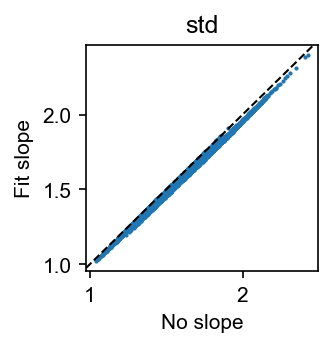

In [60]:
with open(f"cache/{DATASET}.data.pkl", "rb") as f:
    dict_data = pickle.load(f)

n_cal, seed = 5000, 0
df_train, df_test = dict_data[n_cal, seed]

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
colors = ["blue", "red"]
labels = ["Male", "Female"]
for i, (group, df) in enumerate(df_test.groupby("SEX")):
    color = colors[i]
    label = labels[i]
    fit = sm.OLS(endog=df["y"], exog=sm.add_constant(df["pred"])).fit()
    ax.scatter(x=df["pred"], y=df["y"], s=1, color=color, alpha=0.7)
    ax.axline(
        (0, fit.params.const),
        slope=fit.params.pred,
        color=color,
        label=label + f" (y={fit.params.pred:.1f}x{fit.params.const:+.2f})",
    )
# overall
fit = sm.OLS(endog=df_test["y"], exog=sm.add_constant(df_test["pred"])).fit()
ax.axline(
    (0, fit.params.const),
    slope=fit.params.pred,
    color="gray",
    label="Overall" + f" (y={fit.params.pred:.1f}x{fit.params.const:+.1f})",
)
ax.set_xlabel("Point prediction")
ax.set_ylabel("y")
ax.legend(bbox_to_anchor=(0.7, 0.1), loc="center", fontsize=8, frameon=False)

xlim = df_test["pred"].abs().max() * 1.05
ax.set_xlim(-xlim, xlim)
ylim = df_test["y"].abs().max() * 1.05
ax.set_ylim(-ylim, ylim)

plt.title("Simulation with variable slope", fontsize=10)
plt.savefig("results/simulation_slope_example.pdf", bbox_inches="tight")
plt.show()

for name in ["fitslope", "noslope"]:
    df_params = pd.read_csv(f"cache/{DATASET}.{name}.params.tsv", sep="\t")
    df_params = df_params[
        (df_params["adjust"] == "all")
        & (df_params["n"] == n_cal)
        & (df_params["seed"] == seed)
    ].drop(columns=["adjust", "n"])

    params = df_params[["param", "est"]].set_index("param")
    df_tmp = calibrate_pred(params, df_test)
    df_tmp.columns = [f"{name}_{col}" for col in df_tmp.columns]
    for col in df_tmp:
        df_test[col] = df_tmp[col]

for metric in ["mean", "std"]:
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    ax.scatter(df_test[f"noslope_{metric}"], df_test[f"fitslope_{metric}"], s=1)
    ax.set_xlabel("No slope")
    ax.set_ylabel("Fit slope")
    ax.axline((2, 2), slope=1, ls="--", color="black", lw=1.0)
    ax.set_title(metric)
    plt.show()

# Summarize coverage

In [5]:
dict_res = {"data": [], "adjust": [], "col": [], "coverage": [], "r2": []}
for seed in tqdm(range(100)):
    df_train, df_test = dict_data[n_cal, seed]
    for name in ["fitslope", "noslope"]:
        df_params = pd.read_csv(f"cache/{DATASET}.{name}.params.tsv", sep="\t")
        params = df_params[
            (df_params["seed"] == seed)
            & (df_params["adjust"] == "all")
            & (df_params["n"] == n_cal)
        ][["param", "est"]].set_index("param")
        df_tmp = calibrate_pred(params, df_test)
        df_tmp.columns = [f"{name}_{col}" for col in df_tmp.columns]
        for col in df_tmp:
            df_test[col] = df_tmp[col]

    for data in ["all", "tail"]:
        if data == "all":
            df_tmp = df_test.copy()
        elif data == "tail":
            df_tmp = df_test[(df_test.pred < -1.96) | (df_test.pred > 1.96)]
        else:
            raise NotImplementedError

        for method in ["fitslope", "noslope"]:
            for group in ["marginal", "AGE", "PC1", "SEX"]:
                if group == "marginal":
                    group_col = None
                else:
                    group_col = f"{group}_q"
                df_tmp_stats = calpgs.compute_group_stats(
                    df=df_tmp,
                    y_col="y",
                    pred_col=f"{method}_mean",
                    predstd_col=f"{method}_std",
                    group_col=group_col,
                )
                if group == "marginal":
                    col, r2, cov = (
                        ["marginal"],
                        [df_tmp_stats["r2"]],
                        [df_tmp_stats["coverage"]],
                    )
                else:
                    col, r2, cov = (
                        [
                            df_tmp_stats.index.name + "_" + str(i)
                            for i in df_tmp_stats.index
                        ],
                        df_tmp_stats["r2"].values,
                        df_tmp_stats["coverage"].values,
                    )
                dict_res["data"].extend([data] * len(col))
                dict_res["adjust"].extend([method] * len(col))
                dict_res["col"].extend(col)
                dict_res["r2"].extend(r2)
                dict_res["coverage"].extend(cov)
df_res = pd.DataFrame(dict_res)

100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


# Plot

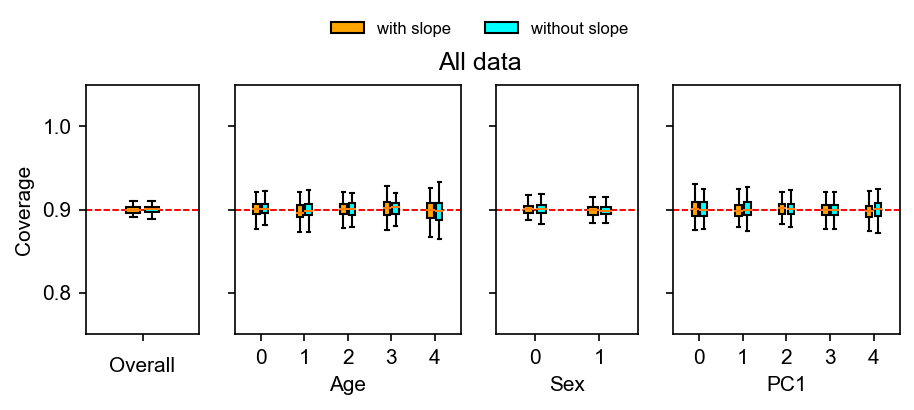

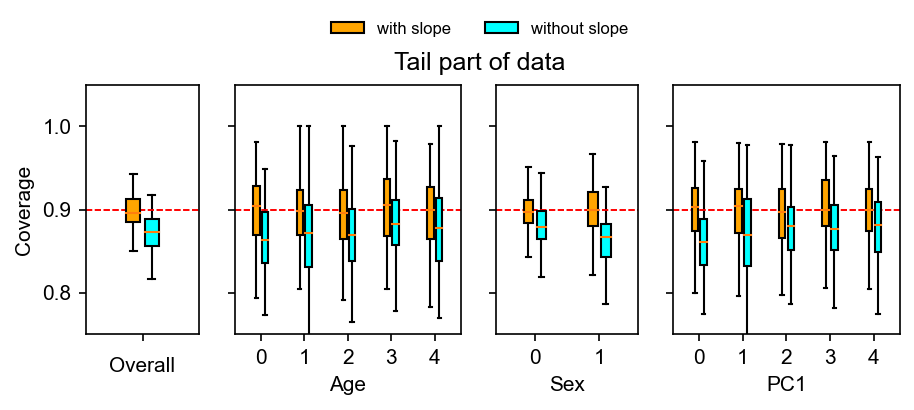

In [6]:
fig, axes = multi_group_plot_wrapper(
    df_stats=df_res.query("data == 'all'"),
    groups=["fitslope", "noslope"],
    colors=["orange", "cyan"],
    labels=["with slope", "without slope"],
    ylim=(0.75, 1.05),
    legend_bbox_to_anchor=(0.5, 1.05),
)
fig.suptitle("All data")
plt.savefig("results/simulation_slope_all.pdf", bbox_inches="tight")

fig, axes = multi_group_plot_wrapper(
    df_stats=df_res.query("data == 'tail'"),
    groups=["fitslope", "noslope"],
    colors=["orange", "cyan"],
    labels=["with slope", "without slope"],
    ylim=(0.75, 1.05),
    legend_bbox_to_anchor=(0.5, 1.05),
)
fig.suptitle("Tail part of data")
plt.savefig("results/simulation_slope_tail.pdf", bbox_inches="tight")

In [7]:
# constant_slope.fitslope
df_true = pd.DataFrame(
    {"constant_slope.fitslope": [0, 1, np.nan, 0.25, 0.2, 0.15, 0, 0, 0]},
    index=[
        "const.beta",
        "pred.beta",
        "const.gamma",
        "AGE.gamma",
        "SEX.gamma",
        "PC1.gamma",
        "AGE.slope",
        "SEX.slope",
        "PC1.slope",
    ],
)
# variable_slope_large.fitslope
df_true["variable_slope_large.fitslope"] = df_true["constant_slope.fitslope"]
df_true.loc[["PC1.slope", "SEX.slope"], "variable_slope_large.fitslope"] = [-0.05, 0.3]
# variable_slope_large.noslope
df_true["variable_slope_large.noslope"] = df_true["variable_slope_large.fitslope"]

In [23]:
dict_df = dict()
dict_name = {
    "constant_slope.fitslope": "Constant slope",
    "variable_slope_large.fitslope": "Variable slope (with slope)",
    "variable_slope_large.noslope": "Variable slope (without slope)",
}

for name in [
    "constant_slope.fitslope",
    "variable_slope_large.fitslope",
    "variable_slope_large.noslope",
]:
    df_params = pd.read_csv(f"cache/{name}.params.tsv", sep="\t")
    df = df_params[(df_params["adjust"] == "all") & (df_params["n"] == 5000)].drop(
        columns=["adjust", "n"]
    )
    df = df.groupby("param").agg(["mean", "sem", "std", "size"])["est"]
    df["True"] = df_true[name].reindex(df.index)
    df["95% CI"] = df.apply(
        lambda row: f"[{row['mean'] - row['sem'] * 1.96:.3f}, {row['mean'] + row['sem'] * 1.96:.3f}]",
        axis=1,
    )
    dict_df[dict_name[name]] = df.iloc[:, -2:]

df_tex = pd.concat(dict_df, axis=1)
df_tex.iloc[:, 4] = df_tex.iloc[:, 2]

df_tex.index.name = None

In [24]:
dict_index = {
    "AGE.gamma": "Age var",
    "SEX.gamma": "Sex var",
    "PC1.gamma": "PC1 var",
    "AGE.slope": "Age slope",
    "SEX.slope": "Sex slope",
    "PC1.slope": "PC1 slope",
    "pred.beta": "Prediction beta",
}

print(
    df_tex.loc[dict_index.keys(), :]
    .rename(index=dict_index)
    .fillna("NA")
    .to_latex(index=True, escape=True, column_format="lrl|rl|rl")
)

\begin{tabular}{lrl|rl|rl}
\toprule
{} & \multicolumn{2}{l}{Constant slope} & \multicolumn{2}{l}{Variable slope (with slope)} & \multicolumn{2}{l}{Variable slope (without slope)} \\
{} &           True &           95\% CI &                        True &            95\% CI &                           True &          95\% CI \\
\midrule
Age var         &           0.25 &   [0.244, 0.252] &                        0.25 &    [0.244, 0.252] &                           0.25 &  [0.234, 0.243] \\
Sex var         &           0.20 &   [0.192, 0.200] &                        0.20 &    [0.192, 0.200] &                           0.20 &  [0.209, 0.217] \\
PC1 var         &           0.15 &   [0.143, 0.153] &                        0.15 &    [0.143, 0.153] &                           0.15 &  [0.139, 0.148] \\
Age slope       &           0.00 &  [-0.005, 0.004] &                        0.00 &   [-0.005, 0.004] &                           0.00 &              NA \\
Sex slope       &           0.00 &  [-0